In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Define Dataset Paths

In [4]:
data_path = '/content/drive/MyDrive/DNN/Datasets/MoNuSeg'
image_dir = os.path.join(data_path, 'images')
mask_dir = os.path.join(data_path, 'masks')

# Load and Preprocess images and masks

In [8]:
IMG_SIZE = (256, 256)

def load_data(image_dir, mask_dir, img_size=IMG_SIZE):
    imgs, msks = [], []

    # Get sorted image and mask file names (filter PNG and BMP)
    ims = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png','.bmp'))])
    mks = sorted([f for f in os.listdir(mask_dir)  if f.lower().endswith(('.png','.bmp'))])

    for imf, mkf in zip(ims, mks):
        img_path = os.path.join(image_dir, imf)
        mask_path = os.path.join(mask_dir, mkf)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Skipping {imf} or {mkf}: file could not be read.")
            continue

        img = cv2.resize(img, img_size) / 255.0
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.float32)[..., None]  # Binary mask (H, W, 1)

        imgs.append(img)
        msks.append(mask)

    return np.array(imgs, dtype=np.float32), np.array(msks, dtype=np.float32)

X, Y = load_data(image_dir, mask_dir)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("✅ All images and masks loaded successfully!")
print(f"Total Images: {X.shape[0]}")
print(f"Image Shape: {X.shape[1:]} | Mask Shape: {Y.shape[1:]}")

print("\n📊 Dataset Split Summary:")
print(f"Training Set:    {X_train.shape[0]} images, {Y_train.shape[0]} masks")
print(f"Validation Set:  {X_val.shape[0]} images, {Y_val.shape[0]} masks")


✅ All images and masks loaded successfully!
Total Images: 58
Image Shape: (256, 256, 3) | Mask Shape: (256, 256, 1)

📊 Dataset Split Summary:
Training Set:    46 images, 46 masks
Validation Set:  12 images, 12 masks


# U-net Model

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def UNet():
    inputs = keras.Input(shape=(256, 256, 3))  # Updated input shape

    # Contracting path
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck (optional)
    b = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p3)
    b = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(b)

    # Expansive path
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(b)
    u4 = layers.concatenate([u4, c3])
    c4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u4)
    c4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = layers.concatenate([u5, c2])
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c1])
    c6 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c6)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c6)

    model = keras.Model(inputs, outputs)
    return model


# Compile and Train

In [10]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=4)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6346 - loss: 0.6733 - val_accuracy: 0.8260 - val_loss: 0.5384
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7628 - loss: 0.5511 - val_accuracy: 0.8260 - val_loss: 0.4163
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7468 - loss: 0.5190 - val_accuracy: 0.8260 - val_loss: 0.3846
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7429 - loss: 0.4996 - val_accuracy: 0.8288 - val_loss: 0.3524
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7837 - loss: 0.4327 - val_accuracy: 0.8570 - val_loss: 0.3161
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8180 - loss: 0.4215 - val_accuracy: 0.8586 - val_loss: 0.3214
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8281 - loss: 0.3728 - val_accuracy: 0.8645 - val_loss: 0.3114
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8399 - loss: 0.3785 - val_accuracy: 0.8747 - v

# Evaluate IoU and Dice

In [11]:
def iou(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

Y_pred = model.predict(X_val)
print("IoU:", iou(Y_val, Y_pred))
print("Dice:", dice(Y_val, Y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
IoU: 0.46970448
Dice: 0.6391822


# Visualize and Sample Prediction

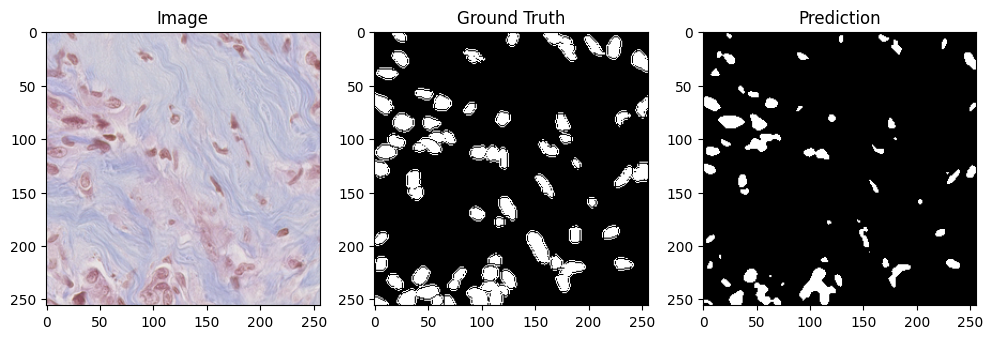

In [12]:
def plot_sample(image, mask, pred):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.show()

plot_sample(X_val[0], Y_val[0], Y_pred[0])

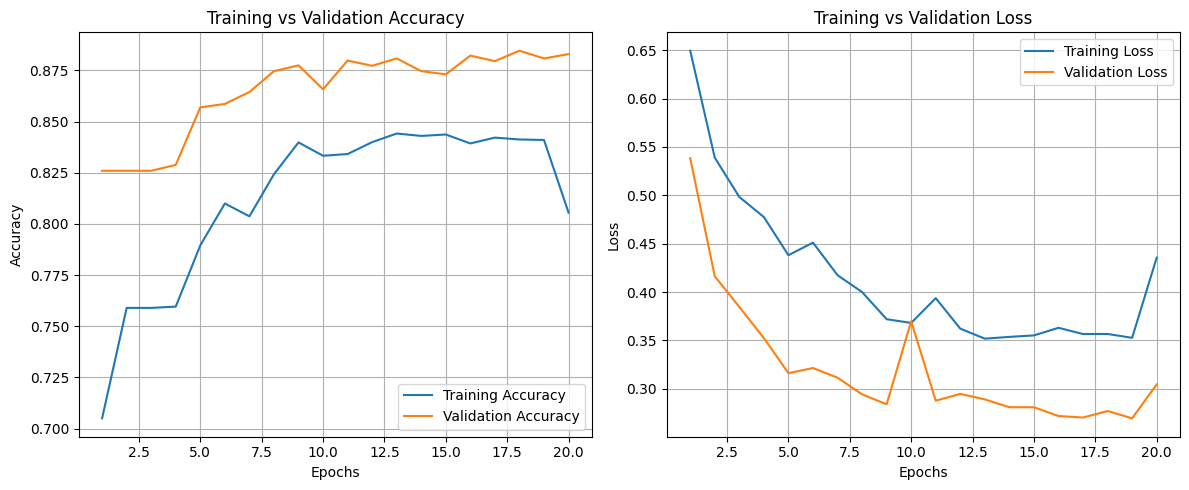

In [13]:
import matplotlib.pyplot as plt

# Extract values from training history
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
